In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.font_manager as fm
from sklearn.decomposition import PCA
import collections
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D
from tensorflow.keras.callbacks import EarlyStopping
import math

In [3]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto' )

In [4]:

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = r'C:/Windows/Fonts/H2GTRM.TTF' # HY견명조 폰트 경로

# 2. FontProperties 객체 생성
font_prop = fm.FontProperties(fname=font_path).get_name()

# 3. 마이너스 부호 설정 (필요한 경우)
plt.rc('font', family=font_prop)

plt.rc('axes', unicode_minus=False)

In [59]:
def create_sequence(data, window_size,target_name):
    y_data= data[target_name].values
    data = data.values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(y_data[i + window_size])
    X, y = np.array(X), np.array(y)
    return X,y

In [5]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [ ]:
def get_saturday(date):
    days_to_saturday = (5 - date.weekday()) % 7
    return date + pd.Timedelta(days=days_to_saturday)


# 데이터 셋 

1. 수온 + 기상 
2. 수온 + 기상 + CNN 특징
3. 수온 + 기상 + CNN + Target
4. 바다환경 
5. 바다환경 + 해상부이
6. 바다환경+ 해상부이+Target

타겟: 어종별 어획률/어획량

In [ ]:
# 어획률 데이터
rate = pd.read_excel('data/어류어획률+어획량.xlsx',sheet_name='어획률')[1:]
rate['금지여부'] = rate['가자미류'].isna().astype(int)
rate.fillna(0,inplace=True)

num = pd.read_excel('data/어류어획률+어획량.xlsx',sheet_name='어획량')[1:]
num['금지여부'] = num['가자미류'].isna().astype(int)
num.fillna(0,inplace=True)



In [91]:
target

['가자미류', '청어', '새우', '대구', '도루묵', '기타어류', '총어획량 ']

# 데이터 불러오기

In [92]:
# 바다온도 + 기상
ocean_data_1 = pd.read_csv('data/surface_Tm+Weather.csv')
ocean_data_1.drop(columns=['관측소'],inplace=True)
ocean_data_1['date'] = pd.to_datetime(ocean_data_1['date'])
ocean_data_1['Week']=ocean_data_1['date'].apply(get_saturday)
ocean_data_1=ocean_data_1.groupby('Week').mean().reset_index().drop(columns='date')
ocean_data_1_rate = rate.merge(ocean_data_1,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_1_rate.set_index('Date',inplace=True)
ocean_data_1_num = num.merge(ocean_data_1,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_1_num.set_index('Date',inplace=True)



# 바다온도 + 기상 + CNN
ocean_data_2 = pd.read_csv('data/surface_Tm+weather+cnn.csv')
ocean_data_2.drop(columns=['관측소'],inplace=True)
ocean_data_2['Date'] = pd.to_datetime(ocean_data_2['Date'])
ocean_data_2['Week']=ocean_data_2['Date'].apply(get_saturday)
ocean_data_2=ocean_data_2.groupby('Week').mean().reset_index().drop(columns='Date')
ocean_data_2_rate = rate.merge(ocean_data_2,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_2_rate.set_index('Date',inplace=True)
ocean_data_2_num = num.merge(ocean_data_2,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_2_num.set_index('Date',inplace=True)

# 바다온도 + 기상 + CNN + 타겟
ocean_data_3 = pd.read_csv('data/surface_Tm+weather+cnn+target.csv')
ocean_data_3['Date'] = pd.to_datetime(ocean_data_3['Date'])
ocean_data_3['Week']=ocean_data_3['Date'].apply(get_saturday)
ocean_data_3=ocean_data_3.groupby('Week').mean().reset_index().drop(columns='Date')
ocean_data_3_rate = rate.merge(ocean_data_3,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_3_rate.set_index('Date',inplace=True)
ocean_data_3_num = num.merge(ocean_data_3,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_3_num.set_index('Date',inplace=True)

# 바다성분 
ocean_data_4 = pd.read_csv('data/ocean_env.csv')
ocean_data_4['time'] = pd.to_datetime(ocean_data_4['time'])
ocean_data_4['Week']=ocean_data_4['time'].apply(get_saturday)
ocean_data_4=ocean_data_4.groupby('Week').mean().reset_index().drop(columns='time')
ocean_data_4_rate = rate.merge(ocean_data_4,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_4_rate.set_index('Date',inplace=True)
ocean_data_4_num = num.merge(ocean_data_4,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_4_num.set_index('Date',inplace=True)

# 바다성분 + 기상
ocean_data_5 = pd.read_csv('data/Ocean_env+Ocean_weather.csv')
ocean_data_5['time'] = pd.to_datetime(ocean_data_5['time'])
ocean_data_5['Week']=ocean_data_5['time'].apply(get_saturday)
ocean_data_5=ocean_data_5.groupby('Week').mean().reset_index().drop(columns='time')
ocean_data_5_rate = rate.merge(ocean_data_5,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_5_rate.set_index('Date',inplace=True)
ocean_data_5_num = num.merge(ocean_data_5,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_5_num.set_index('Date',inplace=True)
# 다 파이널
ocean_data_6 = pd.read_csv('data/rate_ocean_final.csv')
drop_col=ocean_data_6.columns[1:9].to_list()
ocean_data_6.drop(columns=drop_col,inplace=True)
ocean_data_6['Date'] = pd.to_datetime(ocean_data_6['Date'])
ocean_data_6_rate = rate.merge(ocean_data_6,left_on='Date',right_on='Date',how='left')
ocean_data_6_rate.set_index('Date',inplace=True)
ocean_data_6_num = num.merge(ocean_data_6,left_on='Date',right_on='Date',how='left')
ocean_data_6_num.set_index('Date',inplace=True)


In [55]:
ocean_data_6_rate

,가자미류,청어,새우,대구,도루묵,기타어류,총어획량,염분_50m,염분_100m,염분_200m,...,인산염_50m,규산염_50m,mean_광확산 감쇠 계수,평균 풍속(m/s),평균기압(hPa),평균 상대습도(%),평균 기온(°C),평균 최대 파고(m),평균 파주기(sec),Target
Date,,,,,,,,,,,,,,,,,,,,,
2011-03-05,62.7,7.6,6.8,4.1,3.2,15.6,37872.0,34.087777,34.056530,33.998532,...,0.215291,3.534436,0.058370,5.420000,1018.220000,60.000000,4.100000,2.360000,3.680000,4
2011-03-12,48.5,1.6,3.4,2.4,37.8,6.3,79934.0,34.115109,34.077639,34.001785,...,0.211455,3.449480,0.076118,6.785714,1017.542857,53.142857,6.257143,1.957143,2.828571,4
2011-03-19,69.8,7.0,5.0,2.5,5.6,10.1,64910.0,34.147962,34.108084,34.009749,...,0.199250,3.302852,0.070423,6.771429,1017.828571,68.000000,7.457143,2.442857,3.371429,4
2011-03-26,75.1,0.5,5.0,2.6,6.4,10.4,53873.0,34.173486,34.129434,34.007560,...,0.190536,3.145752,0.067224,6.600000,1019.700000,64.000000,6.042857,2.257143,2.971429,4
2011-04-02,80.0,0.0,4.9,5.0,0.8,9.3,86681.0,34.210325,34.145569,34.013618,...,0.158720,2.854243,0.078502,5.171429,1021.400000,64.000000,9.100000,1.357143,2.728571,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04,55.5,1.3,29.1,8.7,0.7,4.7,80427.0,33.642911,33.844457,34.130325,...,0.174976,3.279040,0.041901,9.400000,1020.485714,62.142857,7.742857,2.600000,5.028571,2
2025-01-11,55.0,2.5,27.2,9.0,0.5,5.8,57854.0,33.724002,33.837401,34.110579,...,0.187914,3.278713,0.039323,9.400000,1018.514286,59.000000,4.685714,4.000000,5.785714,2
2025-01-18,51.6,7.4,30.8,3.5,0.6,6.1,86373.0,33.768318,33.842817,34.097062,...,0.197564,3.287962,0.041826,9.400000,1021.900000,59.000000,7.042857,2.700000,4.914286,2


# 특성 추출  

### CNN

In [ ]:
#CNN으로 특징 추출 
def CNN_feature(data,target_data):
    X = data.drop(columns=target_data)
    y= data[target_data]
    y.reset_index(drop=True,inplace=True)
    
    data = np.expand_dims(X,axis=0)
    
    CNN_feature = Sequential()
    CNN_feature.add(Conv1D(filters=64, kernel_size=4,activation='relu',input_shape=(data.shape[1],data.shape[2]),padding='same'))
    CNN_feature.add(Conv1D(filters=32, kernel_size=4,activation='relu',padding='same'))
    CNN_feature.add(Conv1D(filters=16, kernel_size=4,activation='relu',padding='same'))
    CNN_feature.add(Conv1D(filters=8, kernel_size=4,activation='relu',padding='same'))

    CNN_features = CNN_feature.predict(data)

    feature_vector = CNN_features[0]
    feature_columns = [f'cnn_feat_{i}' for i in range(feature_vector.shape[1])]
    df_CNN_features = pd.DataFrame(data=feature_vector,columns=feature_columns)
    df_CNN_features = pd.concat([df_CNN_features,y],axis=1)
    return df_CNN_features

### 단계선택법


In [39]:
#단계법을 통한 특성 추출
def step_select_feature(data,in_n,in_out,target_data,count_n):
    """
    단계법 함수를 통해서 특성 선택을 수행하는 함수
    다항 함수 회귀에서 선택된 특성수 N개 이상인 특성들만 선택

    data : pd.DataFrame
        특성 선택을 위한 데이터 프레임
    
    in_n : float
        특성 선택을 위한 p-value 기준
        (작을수록 엄격함)
    in_out : float 
        특성 제거를 위한 p-value 기준
        (클수록 느슨함)

    target_data : list
        타겟 데이터 이름 (1개 이상가능)

    count_n : int 
        선택된 특성의 개수  기준 점 

    """


    X = data.drop(target_data,axis=1)
    y = data[target_data]

    col=[]
    for i in target_data:
        select_col = stepwise_selection(X, y[i],threshold_in=in_n,threshold_out=in_out ,verbose=False)
        col.append(select_col)
    cb_item=[]
    for current_list in col:
        cb_item.extend(current_list)

    global_counts = collections.Counter(cb_item)
    sorted_counts = sorted(global_counts.items(), key=lambda item: item[1], reverse=True)
    select_col = []
    for item,count in sorted_counts:
        if count>=count_n:
            select_col.append(item)
    select_col = select_col + target
    step_select_df = data[select_col]
    return step_select_df

### PCA

In [36]:
def pca_feature(data,components,target_data):
    X = data.drop(target_data,axis=1)
    y = data[target_data]
    y.reset_index(drop=True,inplace=True)
    pca =PCA(n_components=components)
    x_pca=pca.fit_transform(X)
    feature_columns = [f'pca_feat_{i}' for i in range(x_pca.shape[1])]
    df_pca_features = pd.DataFrame(data=x_pca,columns=feature_columns)
    df_pca_features = pd.concat([df_pca_features,y],axis=1)
    return df_pca_features
 

In [41]:
def total_feature(data,target_data,in_n,in_out,components,count_n):
    """
    CNN, 단계법,PCA 를 통한 특성 선택을 수행하는 함수

    data : pd.DataFrame
        특성 선택을 위한 데이터 프레임
    
    in_n : float
        특성 선택을 위한 p-value 기준
        (작을수록 엄격함)
    in_out : float 
        특성 제거를 위한 p-value 기준
        (클수록 느슨함)

    target_data : list
        타겟 데이터 이름 (1개 이상가능)

    count_n : int 
        선택된 특성의 개수  기준 점 

    components : int or float
        PCA를 통한 특성 선택을 위한 차원 수
        int 선택시 pca 차원수 상위 components개 
        float 선택시 분산의 compnents%되도록 자동 생성 

    """
    # CNN 특징 추출
    cnn_f = CNN_feature(data,target_data)
    # 단계법 특성 선택
    step_f = step_select_feature(data,in_n,in_out,target_data,count_n)
    # PCA
    pca_f =pca_feature(data,components,target_data)
    return cnn_f,step_f,pca_f

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)              │ (None, 727, 64)        │        10,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 727, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 727, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 727, 8)         │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,624 (84.47 KB)

 Trainable params: 21,624 (84.47 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[[  0.         0.        35.985516 ...   0.         0.         0.      ]
 [  0.         0.       167.56262  ...   0.        55.109955   0.      ]
 [  0.         0.       259.33057  ...   0.        99.26156    0.      ]
 ...
 [  0.         0.       264.07346  ...   0.       136.19714    0.      ]
 [113.9354     0.        29.612507 ...   0.        70.768036   0.      ]
 [ 89.25906    0.         0.       ...   0.        93.77762   12.199265]]


In [47]:
pca_f

,pca_feat_0,가자미류,청어,새우,대구,도루묵,기타어류
0,-104025.271167,62.7,7.6,6.8,4.1,3.2,15.6
1,-61963.630769,48.5,1.6,3.4,2.4,37.8,6.3
2,-76987.502520,69.8,7.0,5.0,2.5,5.6,10.1
3,-88024.550142,75.1,0.5,5.0,2.6,6.4,10.4
4,-55216.465009,80.0,0.0,4.9,5.0,0.8,9.3
...,...,...,...,...,...,...,...
722,-61470.478160,55.5,1.3,29.1,8.7,0.7,4.7
723,-84043.746812,55.0,2.5,27.2,9.0,0.5,5.8
724,-55524.181069,51.6,7.4,30.8,3.5,0.6,6.1
725,-32383.111736,59.0,6.7,27.8,0.0,0.3,6.2


# 슬라이딩윈도우 

In [ ]:
def slide_scaler(data, window_size,target_name):
    
    X,y = create_sequence(data, window_size,target_name)
    split_index = int(len(X) * 0.8)
    X_train_raw, y_train_raw = X[:split_index], y[:split_index]
    X_test_raw, y_test_raw = X[split_index:], y[split_index:]
    feauture_num = X_train_raw.shape[2]
    
    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, feauture_num)).reshape(X_train_raw.shape)
    X_test_scaled = scaler.transform(X_test_raw.reshape(-1, feauture_num)).reshape(X_test_raw.shape)
    y_train = y_scaler.fit_transform(y_train_raw.reshape(-1,y_train_raw.shape[1]))
    y_test = y_scaler.transform(y_test_raw.reshape(-1, y_test_raw.shape[1]))
    
    return X_train_scaled, y_train, X_test_scaled, y_test,y_test_raw,y_scaler,scaler 
    

In [ ]:
def test_data_scaler(data,window_size,scaler,y_scaler):
    X,y = create_sequence(data, window_size,target)
    feauture_num = X.shape[2]
    
    X_test_test = scaler.transform(X.reshape(-1, feauture_num)).reshape(X.shape)
    y_test_tset= y_scaler.transform(y.reshape(-1,y.shape[1]))
    
    return X_test_test,y_test_tset

# 기도문 
'국호님 금주기원 기도 0일차'  
'아무 생각이 없ㄷ사 왜냐하면 아무생각이 없기 때문이다'  
'공감하는 바입니다'  
'기본 문법만 아는 사람은 어떻게 특징추출했는지 감도 안잡혀요 '  
'우건님 밤새도록 하시죠'  
'1년반 뒤면 29살 반'  
'우건님 ADsP 합격기원 기도 2일차'  
'전부 빅분기 합격기원 기도 2일차'  
'은서님 빠른 독립기원 기도 2일차'  
'기태님 회사 상장기원 기도 2일차'  


# NN (CNN-RNN-LSTM-FNN)

In [101]:
def percent(data,target_range):
    y_pred = np.maximum(0,data[:,:-1])
    total_y_pred = np.sum(y_pred,axis=1,keepdims=True)
    zero = (total_y_pred==0).flatten()
    if np.any(zero):
        final_pred = 0
    else:
        normal_pred = y_pred/total_y_pred
        final_pred = normal_pred*target_range

    return final_pred

In [123]:
def cnn_plot(data,step,target_name,plot_name,types = 'rate'):
    X_train,y_train,X_test,y_test,y_test_raw,y_scaler= slide_scaler(data,step,target_name)

    # RNN,LSTM은 아래 코드에서 cnn을 각 모델명으로, 그리고 각각의 모델의 맞게 고치면 됩니다.
    Cnn = Sequential()
    Cnn.add(Conv1D(64,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
    Cnn.add(MaxPooling1D(2))
    Cnn.add(Flatten())
    Cnn.add(Dense(32,activation = 'relu'))
    Cnn.add(Dense(16,activation = 'relu'))
    Cnn.add(Dense(y_train.shape[1]))
    Cnn.compile(optimizer='adam', loss='mse')
    Cnn.summary()
    Cnn_history = Cnn.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=[early_stopping])


    plt.plot(Cnn_history.history['loss'], label='Train Loss')
    plt.plot(Cnn_history.history['val_loss'], label='val Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()
    y_pred_scaled = Cnn.predict(X_test)
    if types == 'rate':
        y_pred_origin = y_scaler.inverse_transform(y_pred_scaled)
        y_pred = percent(y_pred_origin,100)
    else:
        y_pred_origin= y_scaler.inverse_transform(y_pred_scaled)
        y_pred_origin = np.maximum(0,y_pred_origin)
    mse= mean_squared_error(y_test_raw, y_pred_origin)
    mae= mean_absolute_error(y_test_raw, y_pred_origin)
    print('MSE:', mse)
    print('MAE:', mae)
    num_target = y_test_raw.shape[1]
    target_names=target_name
    n_cols = 3
    n_rows = math.ceil(num_target / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), squeeze=False)
    axes_flat = axes.flatten()
    last_plotted_idx = -1


    for i, targets in enumerate(target_names):
        # 현재 모델이름에 위치하는 ax축 선택
        if types ==  'rate':            
            if targets == '총어획량 ':
                y_preds = y_pred_origin
            else:
                y_preds = y_pred
        else:
            y_preds =y_pred_origin
        ax = axes_flat[i]
        mse_target = mean_squared_error(y_test_raw[:,i], y_preds[:,i])
        mae_target = mean_absolute_error(y_test_raw[:,i], y_preds[:,i])
        r2 = r2_score(y_test_raw[:,i], y_preds[:,i])
        print(f'{targets} Mse: {mse_target:.4f}, Mae: {mae_target:.4f},R2:{r2}')
        ax.plot(y_test_raw[:, i], label='Actual')
        ax.plot(y_preds[:, i], label='Predicted', linestyle='--')

        # 각 서브플롯 꾸미기
        ax.set_title(f'{targets} Actual vs Predicted\nMSE: {mse_target:.2f}, MAE: {mae_target:.2f}',fontsize=13,fontweight='bold')      # 플롯 제목 설정
        ax.set_xlabel('Date')                    # x축 레이블
        ax.set_ylabel('catchrate(%)')    # y축 레이블 (단위 확인 필요)                         # 그리드 표시
        ax.legend()                               # 범례 표시 확실히 하기
        last_plotted_idx = i
    for j in range(last_plotted_idx+1, len(axes_flat)):
        axes_flat[j].set_visible(False)
    fig.suptitle(f"{plot_name}", fontsize=18, fontweight='bold')
    # 전체 레이아웃 조정 및 플롯 보여주기
    plt.tight_layout()
    # tight_layout() 호출 후 suptitle 공간 확보
    plt.savefig(f'plot/{plot_name}.png')

    plt.show()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_95 (Conv1D)              │ (None, 727, 64)        │        10,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_96 (Conv1D)              │ (None, 727, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_97 (Conv1D)              │ (None, 727, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_98 (Conv1D)              │ (None, 727, 8)         │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,624 (84.47 KB)

 Trainable params: 21,624 (84.47 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[ 52.489883   32.660576  868.7992    ...   0.         99.15114
  109.26357  ]
 [236.16068    30.982664  949.93085   ...   0.         75.633575
    0.       ]
 [181.6359      0.        997.65137   ...   5.697851  166.39233
    0.       ]
 ...
 [301.0591      0.        521.29016   ...   0.         51.507683
    0.       ]
 [  0.          0.        310.8039    ...  58.92067     0.
    0.       ]
 [ 66.67337    11.5201    177.62978   ... 107.65138     6.8936043
    0.       ]]


c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_99 (Conv1D)              │ (None, 55, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │        55,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,959 (226.40 KB)

 Trainable params: 57,959 (226.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0386 - val_loss: 0.0335
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217 - val_loss: 0.0303
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - val_loss: 0.0280
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0266
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - val_loss: 0.0262
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - val_loss: 0.0264
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0263
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - val_loss: 0.0258
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0256
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - val_loss: 0.0253
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0258
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

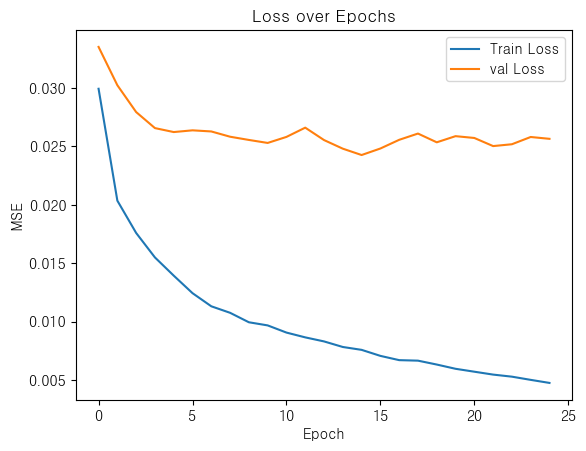

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE: 1728983356.089851
MAE: 27849.10509457866
가자미류 Mse: 846701927.4391, Mae: 22901.4121,R2:-0.14306136500453448
청어 Mse: 1943220742.0042, Mae: 32218.7281,R2:-2.20295103706478
새우 Mse: 214407562.1820, Mae: 10989.6206,R2:-0.5688354793668613
대구 Mse: 1182812052.7712, Mae: 17542.8214,R2:-0.15827271632859885
도루묵 Mse: 2614954946.5067, Mae: 45911.7297,R2:-87.65589641808236
기타어류 Mse: 97323910.0440, Mae: 7212.9757,R2:-0.36589554500787247
총어획량  Mse: 5203462351.6818, Mae: 58166.4481,R2:-0.30714457667657347


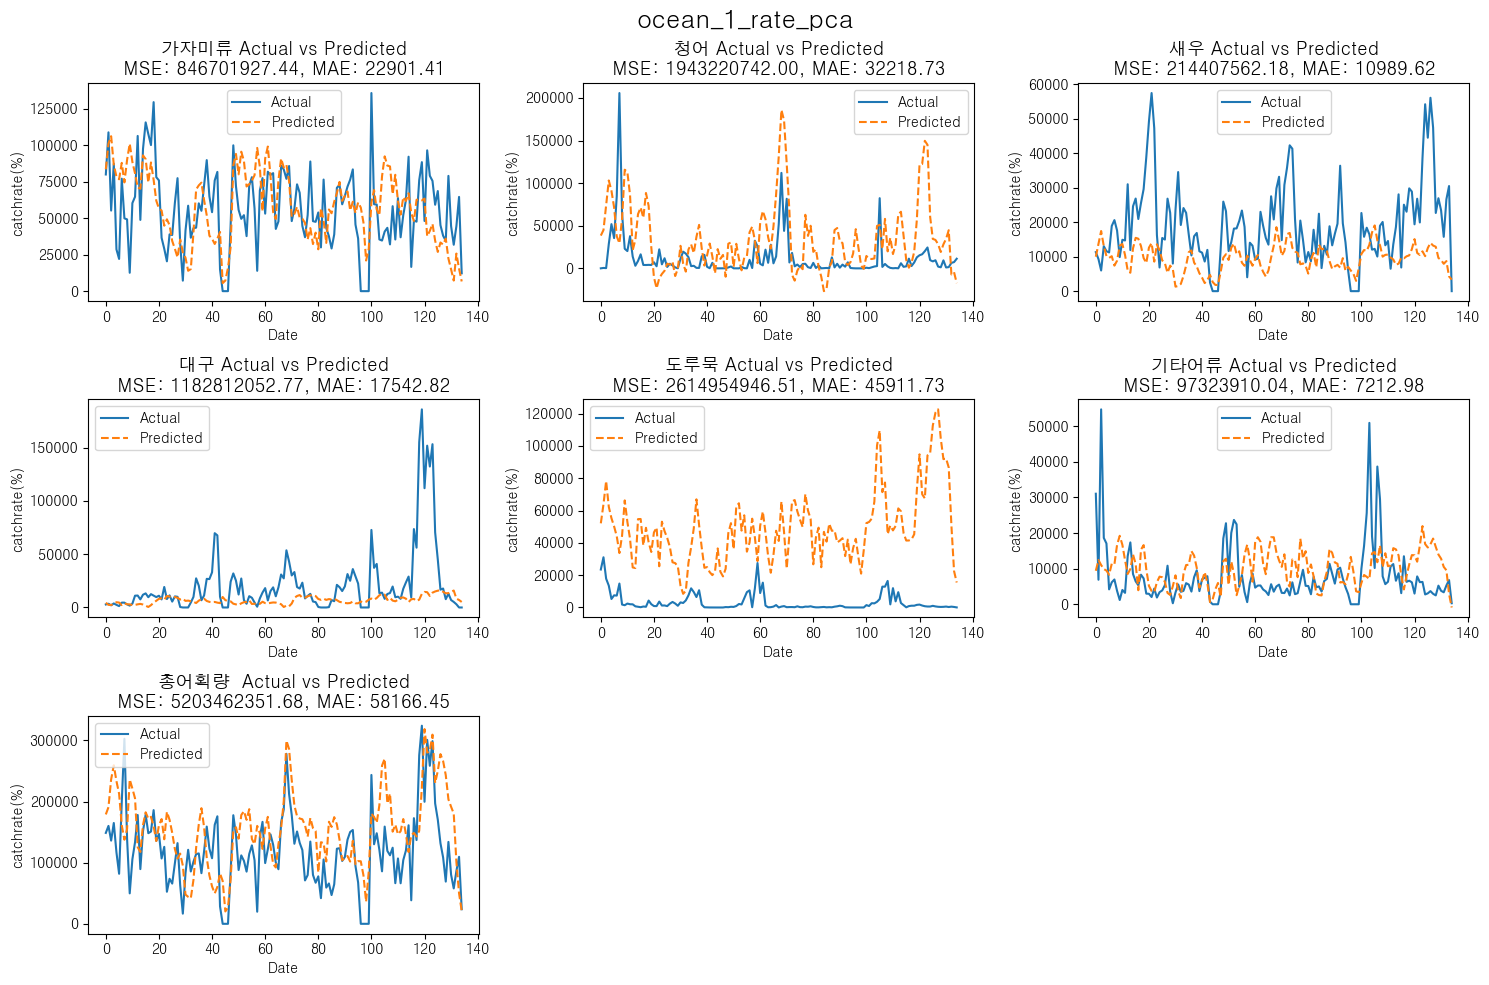

### RNN 
rnn 코드 작성후 돌려주세요

### LSTM

LSTM 코드 작성후 돌려주세요

### FNN


In [124]:
def fnn_plot(data,step,target_name,plot_name,types = 'rate'):
    X_train,y_train,X_test,y_test,y_test_raw,y_scaler= slide_scaler(data,step,target_name)
    X_train_fnn = X_train.reshape(X_train.shape[0], -1)
    X_test_fnn = X_test.reshape(X_test.shape[0], -1)

    # RNN,LSTM은 아래 코드에서 cnn을 각 모델명으로, 그리고 각각의 모델의 맞게 고치면 됩니다.
    Fnn = Sequential()
    Fnn.add(Dense(64, activation='relu', input_dim=X_train_fnn.shape[1]))
    Fnn.add(Dense(32,activation = 'relu'))
    Fnn.add(Dense(16,activation = 'relu'))
    Fnn.add(Dense(y_train.shape[1]))
    Fnn.compile(optimizer='adam', loss='mse')
    Fnn.summary()
    Fnn_history = Fnn.fit(X_train_fnn,y_train,epochs=100,validation_data=(X_test_fnn,y_test),callbacks=[early_stopping])


    plt.plot(Fnn_history.history['loss'], label='Train Loss')
    plt.plot(Fnn_history.history['val_loss'], label='val Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()
    y_pred_scaled = Fnn.predict(X_test_fnn)
    if types == 'rate':
        y_pred_origin = y_scaler.inverse_transform(y_pred_scaled)
        y_pred = percent(y_pred_origin,100)
    else:
        y_pred_origin= y_scaler.inverse_transform(y_pred_scaled)
        y_pred_origin = np.maximum(0,y_pred_origin)
    mse= mean_squared_error(y_test_raw, y_pred_origin)
    mae= mean_absolute_error(y_test_raw, y_pred_origin)
    print('MSE:', mse)
    print('MAE:', mae)
    num_target = y_test_raw.shape[1]
    target_names=target_name
    n_cols = 3
    n_rows = math.ceil(num_target / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), squeeze=False)
    axes_flat = axes.flatten()
    last_plotted_idx = -1


    for i, targets in enumerate(target_names):
        # 현재 모델이름에 위치하는 ax축 선택
        if types ==  'rate':            
            if targets == '총어획량 ':
                y_preds = y_pred_origin
            else:
                y_preds = y_pred
        else:
            y_preds =y_pred_origin
        ax = axes_flat[i]
        mse_target = mean_squared_error(y_test_raw[:,i], y_preds[:,i])
        mae_target = mean_absolute_error(y_test_raw[:,i], y_preds[:,i])
        r2 = r2_score(y_test_raw[:,i], y_preds[:,i])
        print(f'{targets} Mse: {mse_target:.4f}, Mae: {mae_target:.4f},R2:{r2}')
        ax.plot(y_test_raw[:, i], label='Actual')
        ax.plot(y_preds[:, i], label='Predicted', linestyle='--')

        # 각 서브플롯 꾸미기
        ax.set_title(f'{targets} Actual vs Predicted\nMSE: {mse_target:.2f}, MAE: {mae_target:.2f}',fontsize=13,fontweight='bold')      # 플롯 제목 설정
        ax.set_xlabel('Date')                    # x축 레이블
        ax.set_ylabel('catchrate(%)')    # y축 레이블 (단위 확인 필요)                         # 그리드 표시
        ax.legend()                               # 범례 표시 확실히 하기
        last_plotted_idx = i
    for j in range(last_plotted_idx+1, len(axes_flat)):
        axes_flat[j].set_visible(False)
    fig.suptitle(f"{plot_name}", fontsize=18, fontweight='bold')
    # 전체 레이아웃 조정 및 플롯 보여주기
    plt.tight_layout()
    # tight_layout() 호출 후 suptitle 공간 확보
    plt.savefig(f'plot/{plot_name}.png')

    plt.show()

In [ ]:
# data 변경하면서 (cnn_plot 4번째 변수 이름 변경 필수) #주의 ocean_data_3를 한번 돌리면 50분이 걸립니다. 
cnn_f,step_f,pca_f =total_feature(ocean_data_3_num,target,0.05,0.05,0.95,3)
cnn_plot(pca_f,56,target,'ocean_1_rate_cnn_cnn','num')
fnn_plot(pca_f,56,target,'ocean_1_rate_cnn_fnn','num')

In [155]:
ocean_data_4_num.columns

Index(['가자미류', '청어', '새우', '대구', '도루묵', '기타어류', '총어획량 ', '금지여부', '염분_50m',
       '염분_100m', '염분_200m', '염분_300m', '염분_400m', '염분_500m', '해저수온_50m',
       '해저수온_100m', '해저수온_200m', '해저수온_300m', '해저수온_400m', '해저수온_500m',
       '해수유속(E)_50m', '해수유속(E)_100m', '해수유속(E)_200m', '해수유속(E)_300m',
       '해수유속(E)_400m', '해수유속(E)_500m', '해수유속(N)_50m', '해수유속(N)_100m',
       '해수유속(N)_200m', '해수유속(N)_300m', '해수유속(N)_400m', '해수유속(N)_500m',
       'mean_해수면높이', 'mean_혼합층 깊이', '클로로필_50m', '클로로필_100m', '클로로필_200m',
       '클로로필_300m', '클로로필_400m', '클로로필_500m', '질산염_50m', '질산염_100m',
       '질산염_200m', '질산염_300m', '질산염_400m', '질산염_500m', '순 일차 생산량_50m',
       '순 일차 생산량_100m', '순 일차 생산량_200m', '순 일차 생산량_300m', '순 일차 생산량_400m',
       '순 일차 생산량_500m', '용존 산소_50m', '용존 산소_100m', '용존 산소_200m', '용존 산소_300m',
       '용존 산소_400m', '용존 산소_500m', ' 인산염_50m', ' 인산염_100m', ' 인산염_200m',
       ' 인산염_300m', ' 인산염_400m', ' 인산염_500m', '규산염_50m', '규산염_100m',
       '규산염_200m', '규산염_300m', '규산염_400m', '규산염_500m', 'me

In [160]:
test_1=ocean_data_4_num.columns[32:34]

In [130]:
target = rate.columns[1:-2].to_list()

In [ ]:
targets=

In [135]:
ocean_data_1_num['가자미류']

Date
2011-03-05    23746.0
2011-03-12    38768.0
2011-03-19    45307.0
2011-03-26    40459.0
2011-04-02    69345.0
               ...   
2025-01-04    44637.0
2025-01-11    31820.0
2025-01-18    44568.0
2025-01-25    64613.0
2025-02-01    12243.0
Name: 가자미류, Length: 727, dtype: float64

C:\Users\rnrgh\AppData\Local\Temp\ipykernel_31036\1223320278.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()                               # 범례 표시 확실히 하기


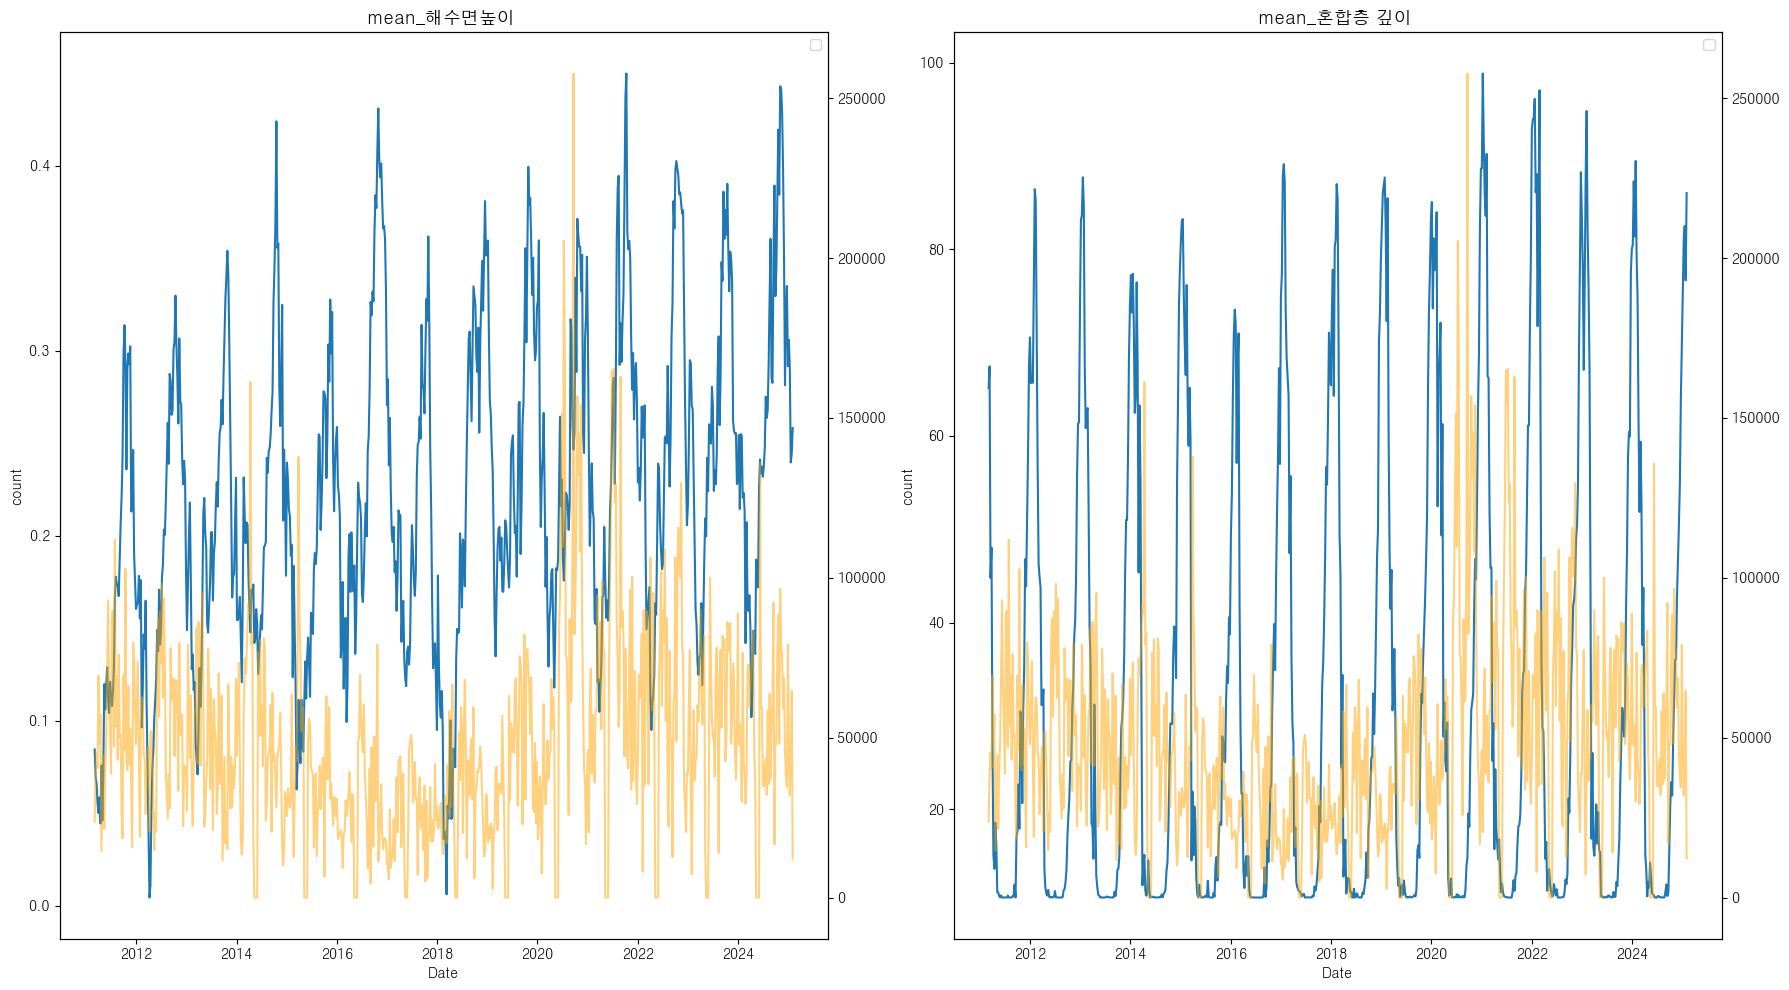

In [162]:
num_target = len(test_1)
target_names=test_1 
n_cols = 2
n_rows = math.ceil(num_target / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), squeeze=False)
axes_flat = axes.flatten()
last_plotted_idx = -1


for i, targets in enumerate(target_names):
    # 현재 모델이름에 위치하는 ax축 선택

    ax = axes_flat[i]

    ax.plot(ocean_data_4_num[targets])
    ax2 = ax.twinx()
    ax2.plot(ocean_data_4_num['가자미류'],color='orange',alpha=0.5)
    

    # 각 서브플롯 꾸미기
    ax.set_title(f'{targets} ',fontsize=13,fontweight='bold')      # 플롯 제목 설정
    ax.set_xlabel('Date')                    # x축 레이블
    ax.set_ylabel('count')    # y축 레이블 (단위 확인 필요)                         # 그리드 표시
    ax.legend()                               # 범례 표시 확실히 하기
    last_plotted_idx = i
for j in range(last_plotted_idx+1, len(axes_flat)):
    axes_flat[j].set_visible(False)
plt.tight_layout()
# tight_layout() 호출 후 suptitle 공간 확보
plt.show()

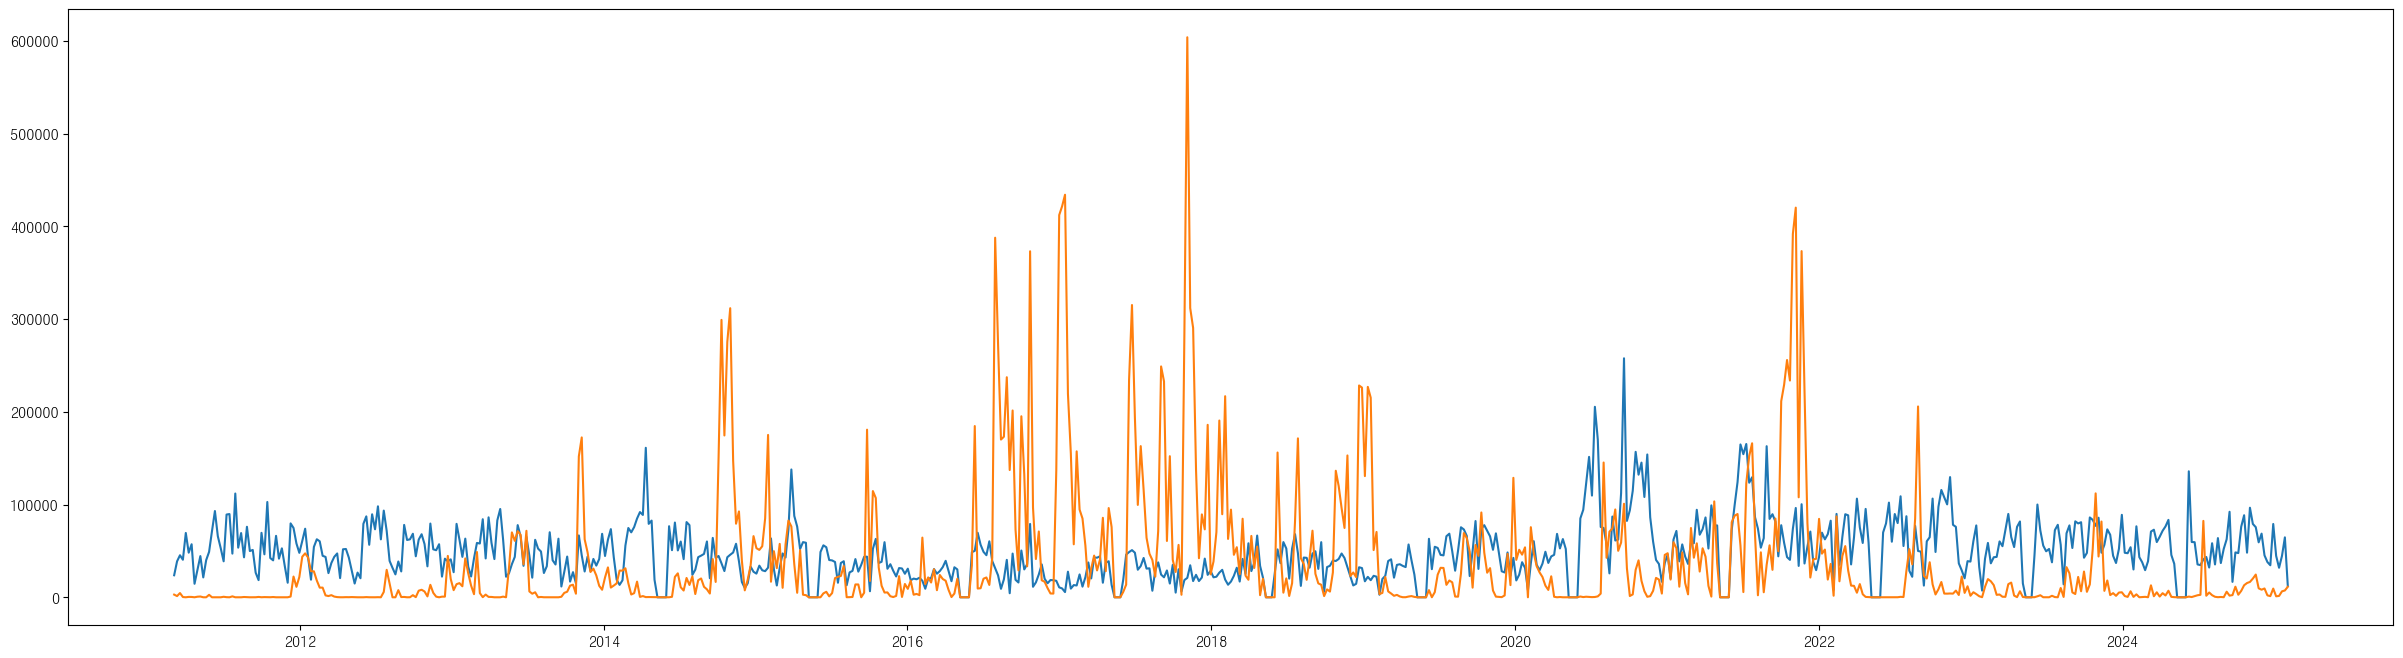

In [172]:
target

plt.figure(figsize=(30,8))
plt.plot(num['Date'],num[target[0]])
plt.plot(num['Date'],num[target[1]])
# plt.plot(rate['Date'],rate[target[2]])
# plt.plot(rate['Date'],rate[target[3]])
# plt.plot(rate['Date'],rate[target[4]])
# plt.plot(rate['Date'],rate[target[5]])

# ML(let's go)